# 서론

해당 노트북의 내용은 한국인 고등학생 대상 한국어 영어 번역 데이터셋을 사용하여 한국어를 영어로 번역하는 모델을 구축하는 것이 목표로 모델의 구조는 Attention is all you need 라는 논문에서 소개된 Transformer 모델을 논문을 보면서 구현하도록 하겠습니다.

# 본론

목차  
1. 초기 환경 설정
2. 필요한 데이터 불러오기

## 1. 초기 환경 설정

### 1.1 한국어 형태소 분석기 Ubuntu 버전 Mecab 설치

!sudo apt-get install curl git  

!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

### 1.2 필요한 패키지들 불러오기

packages라는 이름의 패키지는 현재 작업디렉토리에 존재하는 package라는 폴더로 해당 폴더안에 존재하는 utils라는 python script에 존재하는 모듈들을 불러오기 위해서 사용된 패키지 입니다.

In [25]:
import re
from konlpy.tag import Mecab
from packages import utils # package 폴더에 utils라는 script에 있는 모듈을 불러옵니다.
from tqdm import tqdm

from glob import  glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1.3 matplotlib 한글 깨짐 해결

In [26]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

## 2. 필요한 데이터 불러오기

로드하는 데이터 관련 사이트 : [링크](https://sites.google.com/site/koreanparalleldata/)

해당 데이터는 한국인 고등학생 대상 영어 번역 데이터로 다양한 종류의 주제를 가지고 만들어졌으며 모델의 입력 데이터로는 한국어 문장이 들어가고 출력 데이터로는 영어 문장이 사용되어집니다.

주제 
- 뉴스 기사
- 짧은 스토리
- 편지
- 광고

In [27]:
train_data_path = glob("./data/train/*")
test_data_path = glob("./data/test/*")
dev_data_path = glob("./data/dev/*")

def data_load(data_path):
    result = []
    for setences in data_path:
        with open(setences) as f:
            result += [f.readlines()]
    en, ko = result        
    data = pd.DataFrame({"en":en, "ko":ko})
    return data

train = data_load(train_data_path)
test = data_load(test_data_path)
dev = data_load(dev_data_path)

cp_train = train.copy()
cp_test = test.copy()
cp_dev = dev.copy()

print(f"훈련 데이터 개수 : {cp_train.shape[0]}")
print(f"검증 데이터 개수 : {cp_dev.shape[0]}")
print(f"테스트 데이터 개수 : {cp_test.shape[0]}")
cp_train.head()

훈련 데이터 개수 : 94123
검증 데이터 개수 : 1000
테스트 데이터 개수 : 2000


,en,ko
0,"Much of personal computing is about ""can you t...","개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""\n"
1,so a mention a few weeks ago about a rechargea...,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,"Like all optical mice, But it also doesn't nee...",그러나 이것은 또한 책상도 필요로 하지 않는다.\n
3,uses gyroscopic sensors to control the cursor ...,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
4,Intelligence officials have revealed a spate o...,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...


한국어 영어로된 한 쌍의 문장 데이터로 구성되어

## 3. 데이터 전처리

입출력 데이터를 모델의 학습에 적합한 상태로 만들기 위해서 데이터 전처리 과정을 거쳐야 합니다.  
텍스트 데이터의 경우 거쳐야 하는 기본적인 전처리 과정과 데이터셋의 특성에 따른 추가적인 전처리를 해야하는 경우가 있습니다.  

기본 전처리
- 중복 데이터 제거
- 영어, 한국어에 불필요한 특수문자, 공백 제거
- 결측 데이터 제거

추가 전처리
- 영어, 한국어 텍스트 전처리

### 3.1 중복 데이터 제거

In [28]:
cp_train = cp_train.drop_duplicates("en", keep = "first")
cp_train = cp_train.drop_duplicates("ko", keep = "first").reset_index()

cp_test = cp_test.drop_duplicates("en", keep = "first")
cp_test = cp_test.drop_duplicates("ko", keep = "first").reset_index()

cp_dev = cp_dev.drop_duplicates("en", keep = "first")
cp_dev = cp_dev.drop_duplicates("ko", keep = "first").reset_index()

### 3.2 영어, 한국어에 불필요한 특수문자, 공백 제거

In [29]:
cp_train["ko"] = cp_train["ko"].apply(lambda x : utils.text_preprocessing(x))
cp_train["en"] = cp_train["en"].apply(lambda x : utils.text_preprocessing(x))

cp_test["ko"] = cp_test["ko"].apply(lambda x : utils.text_preprocessing(x))
cp_test["en"] = cp_test["en"].apply(lambda x : utils.text_preprocessing(x))

cp_dev["ko"] = cp_dev["ko"].apply(lambda x : utils.text_preprocessing(x))
cp_dev["en"] = cp_dev["en"].apply(lambda x : utils.text_preprocessing(x))

### 3.3 영어, 한국어 텍스트 전처리

In [30]:
def ko_pre(sentence):
    sentence = re.sub("\n", "", sentence)
    sentence = re.sub("[0-9A-Za-z]+", " ", sentence)
    sentence = re.sub("원문기사보기|이수지|원문기사", "", sentence)
    sentence = re.sub("[ ]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

def en_pre(sentence):
    sentence = "<bos> " + sentence.lower() + " <eos>"
    sentence = re.sub("[0-9ㄱ-ㅎ가-힣]+", " ", sentence)
    sentence = re.sub("[ ]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

cp_train["en"] = cp_train["en"].apply(lambda x: en_pre(x))
cp_dev["en"] = cp_dev["en"].apply(lambda x: en_pre(x))

cp_train["ko"] = cp_train["ko"].apply(lambda x: ko_pre(x))
cp_dev["ko"] = cp_dev["ko"].apply(lambda x: ko_pre(x))

### 3.4 결측 데이터 제거

In [31]:
cp_train = utils.remove_nan(cp_train)
cp_test = utils.remove_nan(cp_test)
cp_dev = utils.remove_nan(cp_dev)

## 4. SentencePiece BPE 방법으로 토큰화

SentencePiece는 서브워드 단위로 분절하는 토큰화 기법으로 Uni-gram 방식과 Byte-Pair-Encoding(BPE) 방식이 존재하는데 해당 노트북에서는 좀 더 성능이 좋다고 알려진 BPE 방식을 채택하겠습니다.

그리고 한 문장에 존재하는 단어의 개수가 50개 이하의 문장을 사용하기 위해서 임시로 모든 문장을 사용한 임시 모델을 만든 뒤 토큰화시켜서 문장별 단어의 개수를 구하고, 다음으로 50개 이하의 단어를 사용한 문장만 뽑아서 다시 본 모델을 만들겠습니다.

SentencePiece 모델을 임시 모델과 본 모델을 나눈 이유는
- 임시 모델에서 사용되지 않는 서브워드가 존재하면 단어장 메모리의 낭비라고 생각했습니다.
- 임시 모델에서 생성된 서브워드보다 본 모델로 생성된 서브워드가 더 가치가 있다고 판단했기 때문입니다.

SentencePiece 모델을 구축하기 위해서 사용될 하이퍼파라미터는 다음과 같습니다.
- model_type = "bpe"
- vocab_size = 20,000

### 4.1 서브단어의 개수를 보기 위한 임시 모델 구축 

#### 한국어 임시 SentencePiece model, vocab 구축

In [32]:
model_type = "bpe"
data = cp_train["ko"]
SRC_VOCAB_SIZE = 20000

add = False # 함수에서 요구하는 파라미터
train_test = "train_ko" # 함수에서 요구하는 파라미터
temp_file = "./spm_ko_train_tmp.tmp" # tmp 파일명

ko_spm_tmp = utils.SentencePiece(model_type, 
                                 data, 
                                 SRC_VOCAB_SIZE, 
                                 add, 
                                 train_test, 
                                 temp_file)

#### 영어 임시 SentencePiece model, vocab 구축

In [33]:
model_type = "bpe"
data = cp_train["en"]
TGT_VOCAB_SIZE = 20000
add = False
train_test = "train_en"
temp_file = "./spm_en_train_tmp.tmp"

en_spm_tmp = utils.SentencePiece(model_type, 
                                 data, 
                                 TGT_VOCAB_SIZE, 
                                 add, 
                                 train_test, 
                                 temp_file)

#### 구축된 SPM모델로 토큰화

In [34]:
# spm에 있는 토큰을 인코딩하면 ("", <bos>)이런식으로 나오기에 ""부분 제거
token_blank_tmp = en_spm_tmp.EncodeAsIds("<bos>")[0]
cp_train["pre_ko"] = cp_train["ko"].apply(lambda x: ko_spm_tmp.encode_as_ids(x))
cp_train["pre_ko"] = cp_train["pre_ko"].apply(lambda x: list(filter((token_blank_tmp).__ne__,x)))

cp_train["pre_en"] = cp_train["en"].apply(lambda x: en_spm_tmp.encode_as_ids(x))
cp_train["pre_en"] = cp_train["pre_en"].apply(lambda x: list(filter((token_blank_tmp).__ne__,x)))

### 4.2 너무 길고 짧은 문장 제거

- 토큰화 시킨 뒤 문장의 길이, 즉 토큰의 개수가 50개 이하, 5개 이상인 데이터는 제거합니다.
- 토큰의 개수를 50개 이하로 한 이유는 해당 프로젝트에서 정한 기준이기 때문입니다.
- 토큰의 개수가 5개로 한 이유는 한국어, 영어 데이터를 전처리 후 결과를 보니 짧은 데이터중에서 쓸모 없는 데이터가 많이 발견되었으며 토큰의 개수가 5개이상 부터는 그럴 듯한 문장이 나오기 때문입니다.

짧거나 긴 문장 제거 전 데이터 개수 : 74760


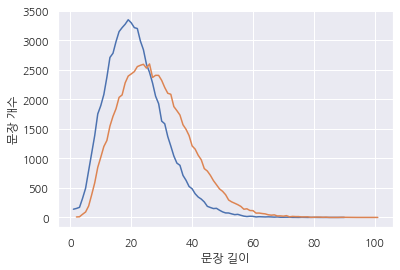

In [35]:
cp_train["pre_ko_len"] = cp_train["pre_ko"].apply(lambda x: len(x))
cp_train["pre_en_len"] = cp_train["pre_en"].apply(lambda x: len(x))
print(f"짧거나 긴 문장 제거 전 데이터 개수 : {cp_train.shape[0]}")

cp_train.groupby("pre_ko_len").count().iloc[:,0].plot()
cp_train.groupby("pre_en_len").count().iloc[:,0].plot()
plt.xlabel("문장 길이")
plt.ylabel("문장 개수")
plt.show()

짧거나 긴 문장 제거 후 데이터 개수 : 70974


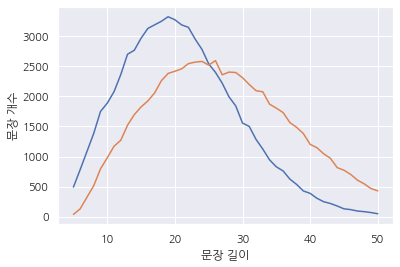

In [36]:
cp_train = cp_train[(cp_train["pre_ko_len"] <= 50) & (cp_train["pre_ko_len"] >= 5)].reset_index(drop=True)
cp_train = cp_train[(cp_train["pre_en_len"] <= 50) & (cp_train["pre_en_len"] >= 5)].reset_index(drop=True)
print(f"짧거나 긴 문장 제거 후 데이터 개수 : {cp_train.shape[0]}")

cp_train.groupby("pre_ko_len").count().iloc[:,0].plot()
cp_train.groupby("pre_en_len").count().iloc[:,0].plot()
plt.xlabel("문장 길이")
plt.ylabel("문장 개수")
plt.show()

### 4.3 SentencePiece 본 모델 구축

#### 영어와 한국어 SentencePiece model, vocab 구축

In [37]:
model_type = "bpe"
data = cp_train["ko"]
SRC_VOCAB_SIZE = 20000

add = False
train_test = "train_ko"
temp_file = "./spm_ko_train.tmp"

ko_spm = utils.SentencePiece(model_type, 
                             data, 
                             SRC_VOCAB_SIZE, 
                             add, 
                             train_test, 
                             temp_file)

In [38]:
model_type = "bpe"
data = cp_train["en"]
TGT_VOCAB_SIZE = 20000
add = False
train_test = "train_en"
temp_file = "./spm_en_train.tmp"

en_spm = utils.SentencePiece(model_type, 
                             data, 
                             TGT_VOCAB_SIZE, 
                             add, 
                             train_test, 
                             temp_file)

#### 구축된 SPM모델로 토큰화

In [39]:
# spm에 있는 토큰을 인코딩하면 ("", <bos>)이런식으로 나오기에 ""부분 제거
token_blank = en_spm.EncodeAsIds("<bos>")[0]
cp_train["pre_ko"] = cp_train["ko"].apply(lambda x: ko_spm.encode_as_ids(x))
cp_train["pre_ko"] = cp_train["pre_ko"].apply(lambda x: list(filter((token_blank).__ne__,x)))

cp_train["pre_en"] = cp_train["en"].apply(lambda x: en_spm.encode_as_ids(x))
cp_train["pre_en"] = cp_train["pre_en"].apply(lambda x: list(filter((token_blank).__ne__,x)))

### 4.4 모든 데이터를 길이 50인 문장으로 패딩

- 패딩 토큰 \<pad>의 id : 1
- 시작 토큰 \<bos>의 id : 4
- 끝 토큰 \<eos>의 id : 5
- 알려지지 않은 서브워드 토큰(unk토큰) " ?? " : 0

In [40]:
x_train = pad_sequences(cp_train["pre_ko"], 
                        maxlen = 50,
                        value = 1,
                        padding = "post")
y_train = pad_sequences(cp_train["pre_en"], 
                        maxlen = 50, 
                        value = 1,
                        padding = "post")

x_train, y_train, x_train.shape, y_train.shape

(array([[ 1409, 18947,  1005, ...,     1,     1,     1],
        [  445,   613, 18887, ...,     1,     1,     1],
        [  186,  2651,   365, ...,     1,     1,     1],
        ...,
        [  186,   127, 19211, ...,     1,     1,     1],
        [  600, 18899,  2118, ...,     1,     1,     1],
        [  492,   600, 18899, ...,     1,     1,     1]], dtype=int32),
 array([[   4, 1113,   37, ...,    1,    1,    1],
        [   4,  384,    7, ...,    1,    1,    1],
        [   4,  589,  306, ...,    1,    1,    1],
        ...,
        [   4,  183,   11, ...,    1,    1,    1],
        [   4, 1072,   45, ...,    1,    1,    1],
        [   4,  345,  152, ...,    1,    1,    1]], dtype=int32),
 (70974, 50),
 (70974, 50))

### 4.5 검증 데이터에도 훈련 데이터에 적용한 부분 똑같이 적용

In [48]:
cp_dev["pre_ko"] = cp_dev["ko"].apply(lambda x: ko_spm.encode_as_ids(x))
cp_dev["pre_ko"] = cp_dev["pre_ko"].apply(lambda x: list(filter((token_blank).__ne__,x)))
cp_dev["pre_en"] = cp_dev["en"].apply(lambda x: en_spm.encode_as_ids(x))
cp_dev["pre_en"] = cp_dev["pre_en"].apply(lambda x: list(filter((token_blank).__ne__,x)))

cp_dev["pre_ko_len"] = cp_dev["pre_ko"].apply(lambda x: len(x))
cp_dev["pre_en_len"] = cp_dev["pre_en"].apply(lambda x: len(x))

cp_dev = cp_dev[cp_dev["pre_ko_len"] <= 50].reset_index(drop=True)
cp_dev = cp_dev[cp_dev["pre_en_len"] <= 50].reset_index(drop=True)

x_dev = pad_sequences(cp_dev["pre_ko"], 
                      maxlen = 50, 
                      value = 1,
                      padding = "post")
y_dev = pad_sequences(cp_dev["pre_en"], 
                      maxlen = 50, 
                      value = 1,
                      padding = "post")

x_dev, y_dev, x_dev.shape, y_dev.shape

(array([[  271,   373,   309, ...,     1,     1,     1],
        [16270,    60,  6282, ...,     1,     1,     1],
        [ 1057,  1333,  1986, ...,     1,     1,     1],
        ...,
        [  899, 18843, 18863, ...,     1,     1,     1],
        [ 2164, 15909,    55, ...,     1,     1,     1],
        [ 1567,  1705, 19504, ...,     1,     1,     1]], dtype=int32),
 array([[    4,   210,  4464, ...,     1,     1,     1],
        [    4,   109,    11, ...,     1,     1,     1],
        [    4,   798,  1145, ...,     1,     1,     1],
        ...,
        [    4,   612, 19995, ...,     1,     1,     1],
        [    4,   528,   508, ...,     1,     1,     1],
        [    4,  2433,  7701, ...,     1,     1,     1]], dtype=int32),
 (938, 50),
 (938, 50))

## 5. Transformer 모델 설계

Attention is all you need 논문에 있는 내용들을 바탕으로 내부 모듈부터 Encoder, Decoder 설계를 시작하겠습니다.

### 5.1 Postional Encoding

![image](https://user-images.githubusercontent.com/51338268/148015775-92c1741a-5975-4eff-b6b7-5417aa408536.png)


![image](https://user-images.githubusercontent.com/51338268/148015862-281ba3c2-2dbb-4d4d-a45d-7f11ba00bb8d.png)

In [49]:
def positional_encoding(pos, d_model = 512):
    def PE(pos, i, d_model):
        if i % 2 == 0:
            return np.sin(pos / (1000**((2*i)/d_model)))
        else:
            return np.cos(pos / (1000**((2*i)/d_model)))
    
    total_tmp = []
    for i in range(pos):
        tmp = []
        for j in range(d_model):
            tmp += [PE(i, j, d_model)]
        total_tmp += [tmp]
    return np.array(total_tmp)

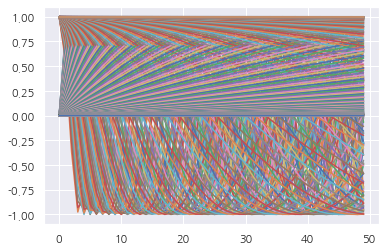

In [50]:
ex = positional_encoding(50, 512)
plt.plot(ex)
plt.show()

### 5.2 Scaled Dot-Product Attention

![image](https://user-images.githubusercontent.com/51338268/148015901-2b54bcef-99dc-4e8e-b05d-a1a68be45573.png)

![image](https://user-images.githubusercontent.com/51338268/148016159-5c338069-ca87-46fc-b824-c27186abc191.png)

Scaled dot product attention의 기본 구조는 위와 같습니다.

masked attention을 적용하기 위한 내용은 다음과 같습니다.

![image](https://user-images.githubusercontent.com/51338268/148017092-84201c0a-524f-4ba9-8aae-e210135e927a.png)

self-attention에서 masking을 시키는 부분의 위치를 설명하자면 i번째 위치의 단어를 예측하기 위해서 오직 i번째보다 작은 위치의 결과만 사용한다는 의미로 그림으로 설명하면 다음과 같습니다.

[![image](https://user-images.githubusercontent.com/51338268/148023579-60365950-79c2-4bb9-a33d-62ee02f9d61e.png)](https://aimb.tistory.com/182)

![image](https://user-images.githubusercontent.com/51338268/148016406-03f6dcbe-e894-467c-a2dd-c1b0aa26b12a.png)

이 내용을 통하여 attention에서 masking되어지는 부분은 $-\infty$로 적용되어집니다.

In [51]:
class ScaledDotAttn(tf.keras.layers.Layer):
    
    def __init__(self, d_model, masked = None):
        super(ScaledDotAttn, self).__init__()
        self.d_model = d_model
        self.masked = masked
        self.query = tf.keras.layers.Dense(d_model)
        self.key = tf.keras.layers.Dense(d_model)
        self.value = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self, x, context_vector = None):
        batch_size = x.shape[0]
        query = self.query(tf.identity(x))
        # encoder-decoder attention
        if context_vector is not None:
            key = self.key(tf.identity(context_vector))
        else:
            key = self.key(tf.identity(x))
        if context_vector is not None:
            value = self.value(tf.identity(context_vector))
        else:
            value = self.value(tf.identity(x))
        
        batch_bucket = []
        for batch in range(batch_size):
            query_key = tf.linalg.matmul(query[batch], tf.transpose(key[batch]))
            scaled_query_key = query_key / np.sqrt(self.d_model)
            
            # masked self-attention
            if self.masked is not None:
                trill_key_query = np.tril(scaled_query_key, 0)
                masked_key_query = np.where(trill_key_query == 0, -1e9, trill_key_query)
                softmax = self.softmax(masked_key_query) # softmax를 하면 masking부분이 0이 됩니다.
            else:
                softmax = self.softmax(scaled_query_key)
            out = tf.linalg.matmul(softmax, value[batch])
            batch_bucket += [out.numpy()]
            
        out = tf.constant(batch_bucket)
        return out

In [52]:
x_train_part = x_train[:60]
embedd = tf.keras.layers.Embedding(20000, 512)
ex = embedd(x_train_part)

In [53]:
attn = ScaledDotAttn(512)
ex1 = attn(ex)
ex1.shape

TensorShape([60, 50, 512])

### 5.3 Multi-Head Attention

![image](https://user-images.githubusercontent.com/51338268/148016116-32d483db-19e4-4f58-b6db-f00e1beff458.png)

![image](https://user-images.githubusercontent.com/51338268/148016190-7404e52b-5ed8-4b1a-bf34-a31f4f3697f1.png)

Multi head attention에서 입력의 차원이 512개라서 8개의 head로 나누면 각 attention은 64개의 차원을 가지고, scaled-dot product를 적용하기 전에 linear를 사용합니다.

In [54]:
class MultiHeadAttn(tf.keras.layers.Layer):
    
    def __init__(self, h, d_model, masked = None):
        super(MultiHeadAttn, self).__init__()
        self.h = h
        self.d_model = d_model
        self.masked = masked
        self.partitions = self.d_model // self.h
        self.attn = ScaledDotAttn(self.partitions, self.masked)
        self.outputs = tf.keras.layers.Dense(self.d_model)
        
    def call(self, x, context_vector = None):
        bucket_out = []
        for i in range(self.h):
            part_x = x[:,:,(i*self.partitions):((i+1)*self.partitions)]
            part_x = self.attn(part_x, context_vector)
            bucket_out += [part_x]
        bucket_out = tf.concat(bucket_out, axis = -1)
        bucket_out = self.outputs(bucket_out)
        return bucket_out

In [55]:
multi = MultiHeadAttn(8, 512)
aa = multi(ex)
aa.shape

TensorShape([60, 50, 512])

### 5.4 Postion-Wise Feed Forward Network

![image](https://user-images.githubusercontent.com/51338268/148016328-bc152787-a3bb-4f72-9227-458ddb457a0f.png)

![image](https://user-images.githubusercontent.com/51338268/148016356-8816ab24-1515-4804-8c3b-d367d3d7b1c3.png)

In [56]:
class PostionWiseFFN(tf.keras.layers.Layer):
    
    def __init__(self, d_model):
        super(PostionWiseFFN, self).__init__()
        self.d_model = d_model
        self.linear1 = tf.keras.layers.Dense(self.d_model, activation = "relu")
        self.linear2 = tf.keras.layers.Dense(self.d_model)
        
    def call(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [57]:
ffn = PostionWiseFFN(512)
bb = ffn(aa)
bb.shape

TensorShape([60, 50, 512])

### 5.5 Encoder

![image](https://user-images.githubusercontent.com/51338268/148025900-4279f42e-5d76-43c4-a7dd-93a36866ede7.png)

![image](https://user-images.githubusercontent.com/51338268/148027441-42214b02-61ad-4844-bd09-5e06c96b2f0f.png)

![image](https://user-images.githubusercontent.com/51338268/148028185-9581a303-eb79-47d9-9366-e61b8b344233.png)

![image](https://user-images.githubusercontent.com/51338268/148028026-a0a846e3-8190-45cb-93dd-08a980ef5aa5.png)

In [58]:
class EncoderLayer(tf.keras.layers.Layer):
    
    def __init__(self, h, vocab_size, length, d_model):
        super(EncoderLayer, self).__init__()
        self.h = h
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.length = length
        self.embedd = tf.keras.layers.Embedding(self.vocab_size,
                                                self.d_model)
        self.position_encoding = positional_encoding(self.length, self.d_model)
        self.multiattn = MultiHeadAttn(self.h, self.d_model)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.ffn = PostionWiseFFN(self.d_model)
        self.dropout = tf.keras.layers.Dropout(0.1)
        
        
    def call(self, x):
        x = tf.expand_dims(x, 1)
        x = self.embedd(x)
        x = x + self.position_encoding

        skip1 = tf.identity(x)
        x = self.multiattn(x)
        x = self.dropout(x)
        x += skip1
        x = self.layernorm(x)
        
        skip2 = tf.identity(x)
        x = self.ffn(x)
        x = self.dropout(x)
        x += skip2
        x = self.layernorm(x)
        return x

In [59]:
h = 8
vocab_size = 20000
length = 1
d_model = 512
encoder = EncoderLayer(h, vocab_size, length, d_model)
example = encoder(x_train_part[:,0])
example.shape

TensorShape([60, 1, 512])

### 5.6 Decoder

![image](https://user-images.githubusercontent.com/51338268/148028900-1786cebc-76b0-4554-9cdb-49e682d04893.png)

![image](https://user-images.githubusercontent.com/51338268/148028944-899ee115-0f07-4ad8-8302-e0b083a1b988.png)

![image](https://user-images.githubusercontent.com/51338268/148037996-83501552-8b81-45b7-807f-1e016ae56eba.png)

In [60]:
class DecoderLayer(tf.keras.layers.Layer):
    
    def __init__(self, h, vocab_size, length, d_model):
        super(DecoderLayer, self).__init__()
        self.h = h
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.length = length
        
        self.embedd = tf.keras.layers.Embedding(self.vocab_size,
                                                self.d_model)
        self.position_encoding = positional_encoding(self.length, self.d_model)
        
        self.multiattn = MultiHeadAttn(self.h, self.d_model)
        self.masked_multiattn = MultiHeadAttn(self.h, self.d_model, masked = True)
        self.cross_multiattn = MultiHeadAttn(self.h, self.d_model)
        self.ffn = PostionWiseFFN(self.d_model)
        
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.dropout = tf.keras.layers.Dropout(0.1)

        self.linear = tf.keras.layers.Dense(vocab_size)
        self.softmax = tf.keras.layers.Softmax(axis = -1)
        
    def call(self, x, context_vector):
        x = tf.expand_dims(x, 1)
        # sub-layer 1
        x = self.embedd(x)
        x = x + self.position_encoding
        skip1 = tf.identity(x)
        x = self.masked_multiattn(x)
        x = self.dropout(x)
        x += skip1
        x = self.layernorm(x)
        # sub-layer 2
        skip2 = tf.identity(x)
        x = self.cross_multiattn(x, context_vector)
        x = self.dropout(x)
        x += skip2
        x = self.layernorm(x)
        # sub-layer 3
        skip3 = tf.identity(x)
        x = self.ffn(x)
        x = self.dropout(x)
        x += skip3
        x = self.layernorm(x)
        
        # output-layer
        x = self.linear(x)
        x = self.softmax(x)
        x = x[:,0,:]
        return x

In [61]:
y_train_part = y_train[:60]

h = 8
vocab_size = 20000
length = 1
d_model = 512
decoder = DecoderLayer(h, vocab_size, length, d_model)
example2 = decoder(y_train_part[:,0], example)
example2.shape

TensorShape([60, 20000])

### 5.7 Loss function and optimizer

categoricalcrossentropy 참고 사이트 : https://guru.tistory.com/67

In [62]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## 6. Transformer 모델 학습

모델 학습에 필요한 파라미터들을 미리 지정해줍니다.
- h = Multi Head Attention에서 head의 개수
- vocab_size = SentencePiece 모델의 단어장 크기
- d_model = 각 서브층에 존재하는 유닛의 개수
- batch_size = 한 step마다 모델에 들어가는 데이터의 개수
- epoch = 모델 학습 횟수
- length = 모델이 학습시 예측할 단어의 개수

In [72]:
h = 8
vocab_size = 20000
length = 1
d_model = 512
batch_size = 32
epoch = 1
encoder_input = x_train
decoder_input = y_train[:, :-1]
decoder_output = y_train[:, 1:]

encoder = EncoderLayer(h, vocab_size, length, d_model)
decoder = DecoderLayer(h, vocab_size, length, d_model)
decoder_length = decoder_input.shape[1]
steps = x_train.shape[0] // batch_size

#idx_list = list(range(0, x_train.shape[0], batch_size))
idx_list = list(range(0, batch_size*2, batch_size))
t = tqdm(idx_list)

  0%|          | 0/2 [00:00<?, ?it/s]

In [73]:
for batch, idx in enumerate(t):

    batch_encoder_input = x_train[idx:(idx+batch_size)]
    batch_decoder_input = y_train[idx:(idx+batch_size), :-1]
    batch_decoder_output = y_train[idx:(idx+batch_size), 1:]
    loss = 0

    with tf.GradientTape() as tape:
        for time in range(decoder_length):
            context_vector = encoder(batch_encoder_input[:, time])
            # loss에 들어가는 preds, reals는 numpy가 아닌 tensor로 바꿔줘야합니다.
            preds = decoder(batch_decoder_input[:, time], context_vector) # [batch_size, vocab_size]
            reals = tf.constant(batch_decoder_output[:, time].reshape(-1, 1)) # [batch_size, 1]
            loss += loss_function(reals, preds) # scalar

    batch_loss = loss.numpy() / decoder_length
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    t.set_description_str('Epoch %2d' % (epoch + 1))
    t.set_postfix_str('Loss %.4f' % (batch_loss / (batch + 1)))

Epoch  2:  50%|█████     | 1/2 [01:03<01:03, 63.52s/it, Loss 9.8972]

9.897165103834503


Epoch  2: 100%|██████████| 2/2 [01:59<00:00, 59.54s/it, Loss 4.9517]

9.903480374083227


## 7. 모델 검증

In [167]:
inputs = "나는 배가 고프다."
token_inputs = ko_spm.EncodeAsIds(inputs)
token_length = len(token_inputs)
token_inputs = pad_sequences([token_inputs],
                             maxlen = 50,
                             value = 1,
                             padding = "post")
en_bos_token = en_spm.EncodeAsIds("<bos>")[-1]
en_bos_token = np.array([en_bos_token])

outputs = ""

for t in range(token_length):
    context = encoder(token_inputs[:,t])
    prediction = decoder(en_bos_token, context)
    prediction_id = np.argmax(prediction, axis=1)    
    prediction_word = en_spm.DecodeIds([int(prediction_id)])
    if prediction_word == "<eos>":
        break
    en_bos_token = np.array(prediction_id)

    outputs += prediction_word + " "

print(f"입력 문장 : {inputs}")
print(f"출력 문장 : {outputs}")

입력 문장 : 나는 배가 고프다.
출력 문장 : exposed exposed exposed exposed exposed exposed 


## 8. 회고

#### 느낀점

- 처음으로 논문만 보면서 모델을 구현하고 직접 학습까지 돌려서 결과가 어떻게 나오는지 까지 일련의 과정을 거치면서 생각보다 재미있고 논문을 구현하는데 너무 겁을 먹을 필요는 없다는 생각이 들었습니다.
- 모르거나 막히는 경우 조원분들에게 여쭤보거나 퍼실분들께 질문하면서 느낀 점은 논문의 기술들을 구현하는 요소들은 모두 논문안에 있다는 생각이 들었으며 각 기술들은 그림으로만 힌트를 주는게 아닌 글에서도 찾아야 한다는 것을 느꼈습니다.
- 해당 논문을 읽은 것은 일주일 전으로 2일 정도 나눠서 모두 읽고 구현하는 부분은 3일 정도 걸린 것으로 보아 논문 하나를 잡고 구현하는데 2주 정도 잡으면 넉넉하겠다는 생각이 들었습니다.

#### 아쉬운 점

- Decoder Output부분에서 \<eos>토큰이 제대로 빠지지 못한 형태이기 때문에 해당 토큰의 영향력이 줄을걸로 예상됩니다.
- 아쉬운 점은 Encoder와 Decoder의 Layer부분을 층으로 쌓지 못하는 형태로 구현하였기에 차후에 형태를 수정해야합니다.
- 논문을 모두 읽자마자 바로 구현 작업에 들어가야 생각나고 공부되는 부분이 많았을 텐데 시간이 지나고 하니 다시 공부하느라 시간이 상당히 소모되었다고 느꼈습니다.